In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [ ]:
cuda = torch.cuda.is_available()
device = "cuda:0" if cuda else "cpu"
print("cuda: ", cuda)

cuda:  True


In [ ]:
batch_size = 100

data = {
    "train": torchvision.datasets.FashionMNIST(
        root="data",
        train=True,
        transform=torchvision.transforms.ToTensor(),
        download=True,
    ),
    "test": torchvision.datasets.FashionMNIST(
        root="data", train=False, transform=torchvision.transforms.ToTensor()
    ),
}

loader = {
    "train": torch.utils.data.DataLoader(
        data["train"], batch_size, shuffle=False, num_workers=1
    ),
    "test": torch.utils.data.DataLoader(
        data["test"], batch_size, shuffle=False, num_workers=1
    ),
}

In [ ]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, 5, 1, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )
        self.out = torch.nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x


cnn = CNN()

if cuda:
    cnn.to(device)

In [ ]:
num_epochs = 13


def train(num_epochs, cnn, loader):
    cnn.train()
    total_step = len(loader["train"])
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=0.007)

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loader["train"]):
            if cuda:
                images = images.to(device)
                labels = labels.to(device)

            b_x = torch.autograd.Variable(images)
            b_y = torch.autograd.Variable(labels)

            output = cnn(b_x)[0]
            loss = loss_function(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:
                print(
                    "Epoch [{}/{}] | Step [{}/{}] | Loss: {:.3f}".format(
                        epoch + 1, num_epochs, i + 1, total_step, loss.item()
                    )
                )


train(num_epochs, cnn, loader)

Epoch [1/13] | Step [100/600] | Loss: 0.439
Epoch [1/13] | Step [200/600] | Loss: 0.434
Epoch [1/13] | Step [300/600] | Loss: 0.401
Epoch [1/13] | Step [400/600] | Loss: 0.377
Epoch [1/13] | Step [500/600] | Loss: 0.439
Epoch [1/13] | Step [600/600] | Loss: 0.301
Epoch [2/13] | Step [100/600] | Loss: 0.271
Epoch [2/13] | Step [200/600] | Loss: 0.290
Epoch [2/13] | Step [300/600] | Loss: 0.361
Epoch [2/13] | Step [400/600] | Loss: 0.333
Epoch [2/13] | Step [500/600] | Loss: 0.406
Epoch [2/13] | Step [600/600] | Loss: 0.266
Epoch [3/13] | Step [100/600] | Loss: 0.263
Epoch [3/13] | Step [200/600] | Loss: 0.291
Epoch [3/13] | Step [300/600] | Loss: 0.262
Epoch [3/13] | Step [400/600] | Loss: 0.272
Epoch [3/13] | Step [500/600] | Loss: 0.351
Epoch [3/13] | Step [600/600] | Loss: 0.233
Epoch [4/13] | Step [100/600] | Loss: 0.302
Epoch [4/13] | Step [200/600] | Loss: 0.222
Epoch [4/13] | Step [300/600] | Loss: 0.229
Epoch [4/13] | Step [400/600] | Loss: 0.271
Epoch [4/13] | Step [500/600] | 

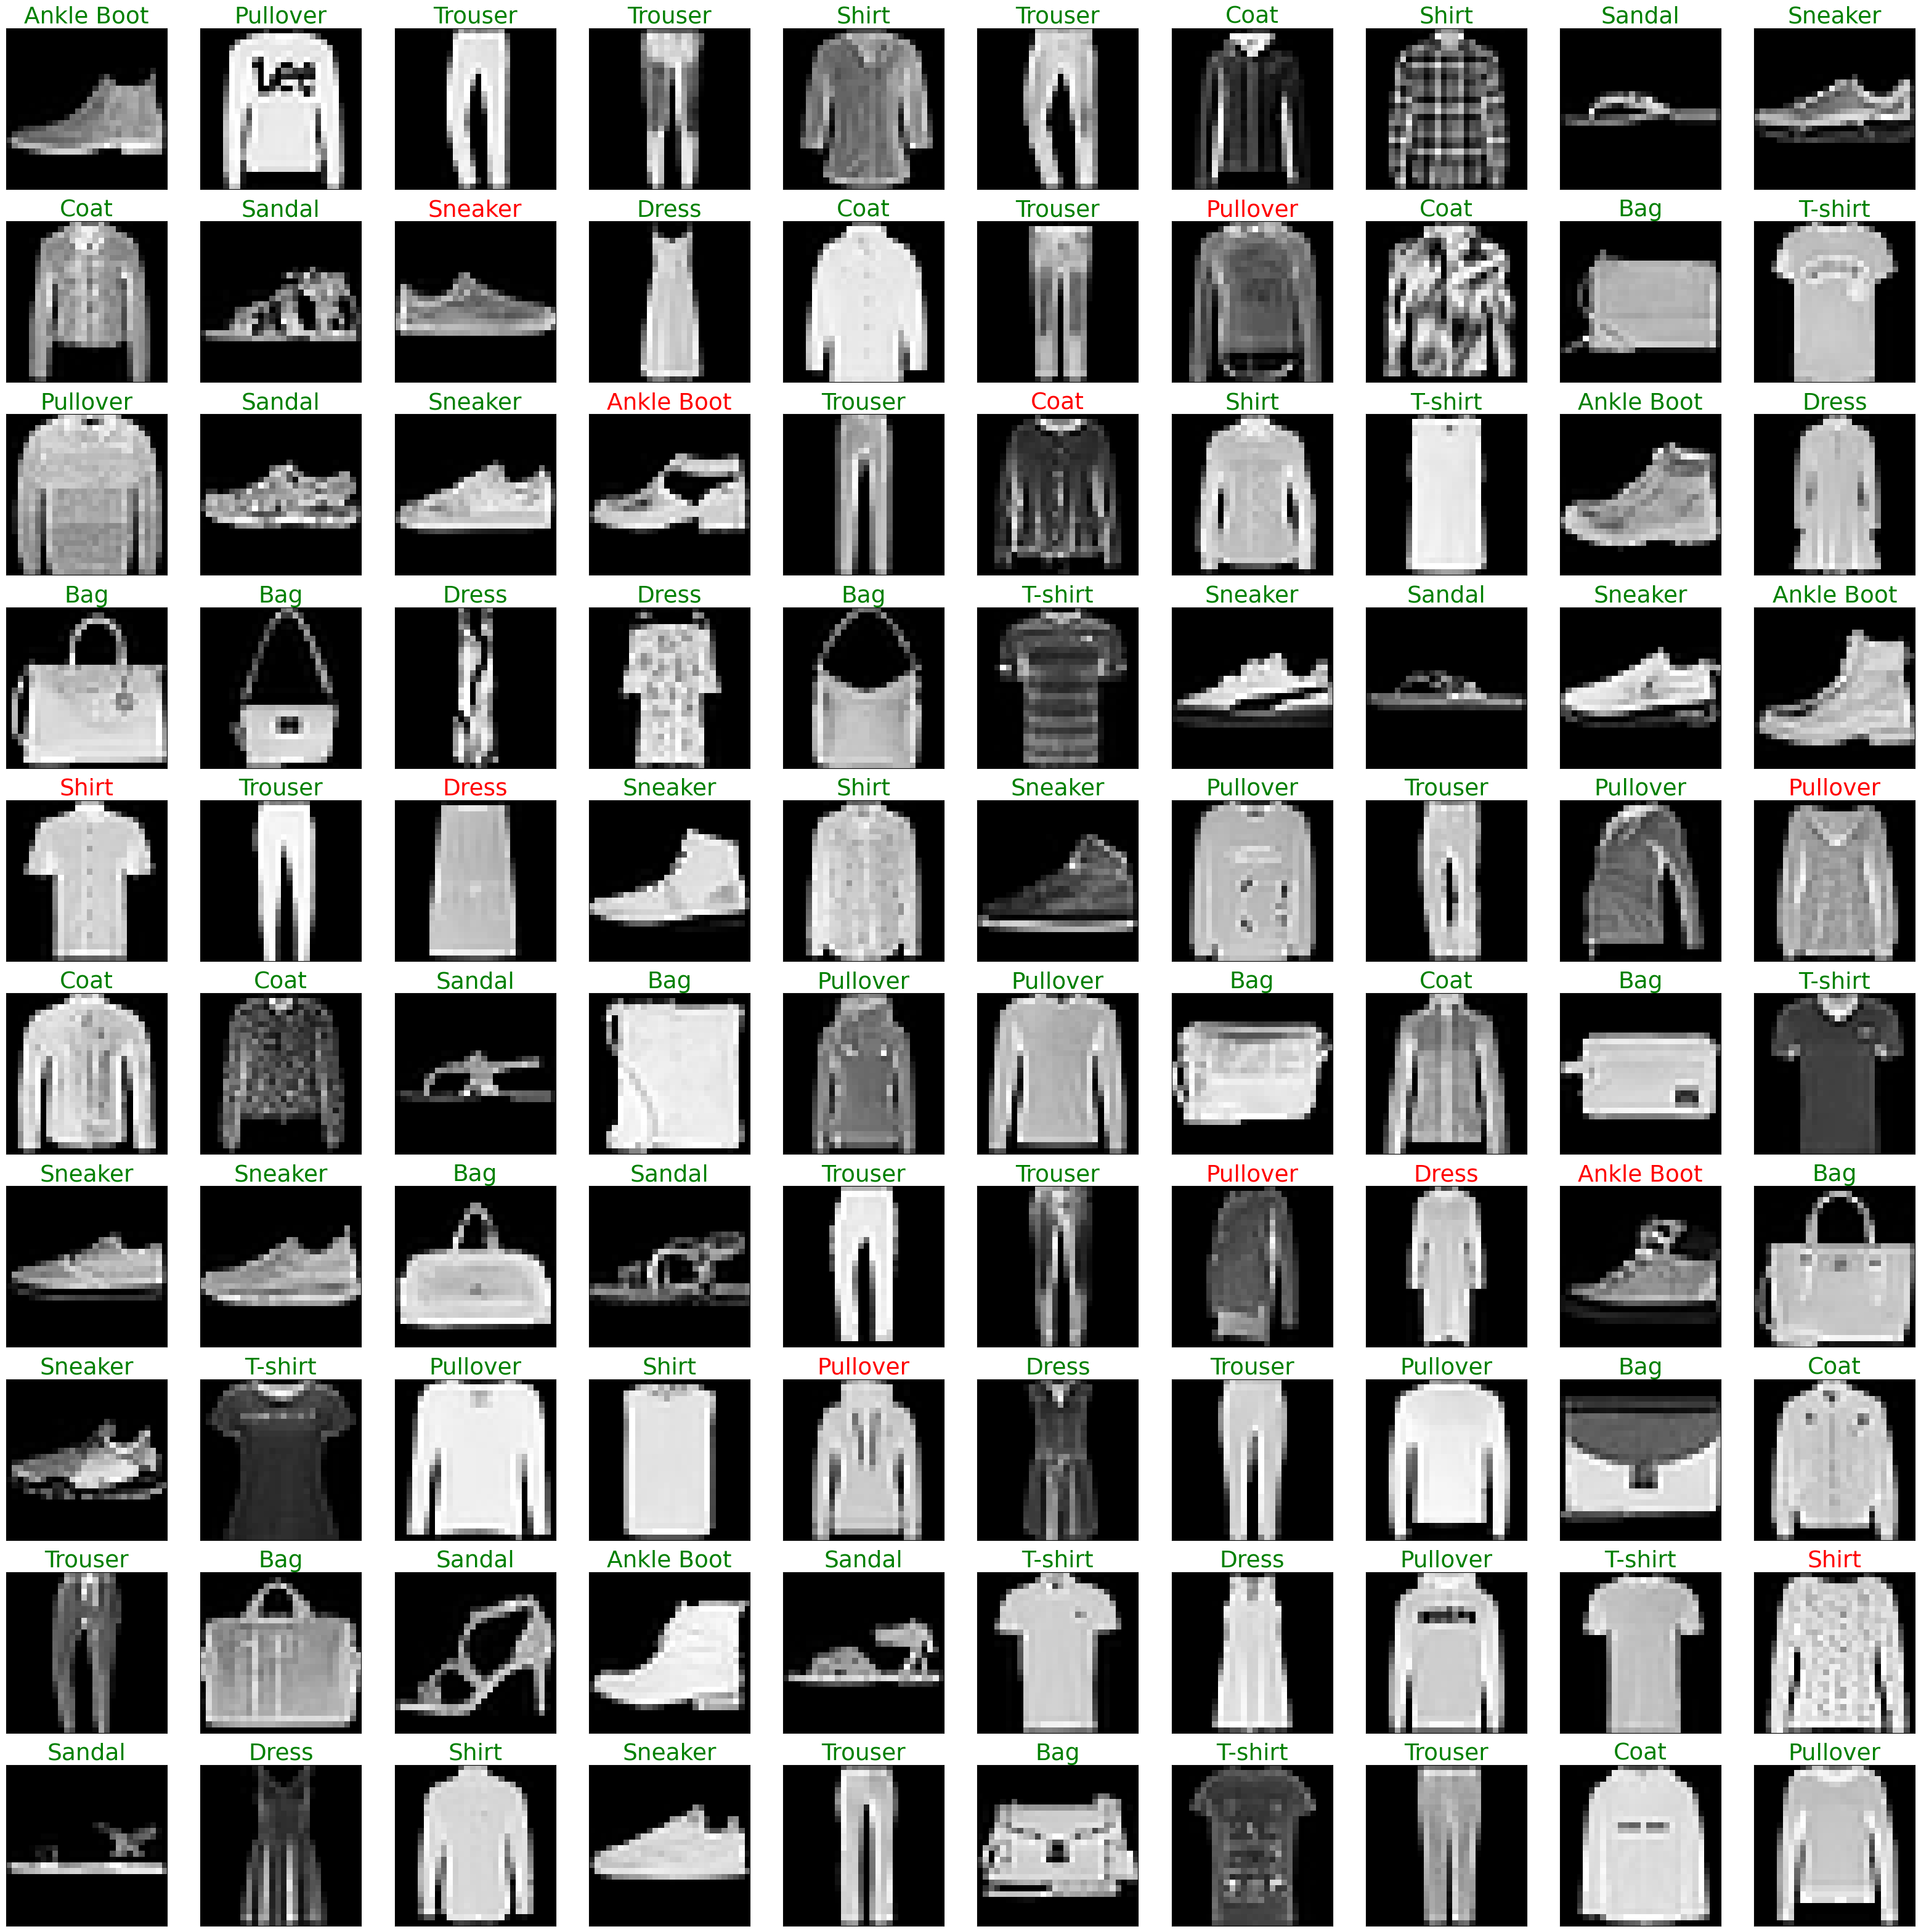


Accuracy on the test images: 88.37%


In [ ]:
def output_label(label):
    output_mapping = {
        0: "T-shirt",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    }

    input = label.item() if type(label) == torch.Tensor else label

    return output_mapping[input]


def test(dataset):
    cnn.eval()
    correct = 0.0
    total = 0.0
    first = True

    with torch.no_grad():
        for images, labels in loader[dataset]:
            if cuda:
                images = images.to(device)
                labels = labels.to(device)

            output, _ = cnn(images)
            _, predict = torch.max(output, 1)
            total += labels.size(0)
            correct += (predict == labels).sum().item()

            if cuda:
                images = images.to("cpu")
                labels = labels.to("cpu")

            if first:
                plt.figure(figsize=(40, 40))
                for i in range(batch_size):
                    plt.subplot(10, 10, i + 1)
                    plt.xticks([])
                    plt.yticks([])
                    plt.grid(False)
                    plt.imshow(images[i].permute(1, 2, 0), cmap="gray")
                    plt.title(
                        "{}".format(output_label(labels[i])),
                        fontsize=27,
                        color=("green" if predict[i] == labels[i] else "red"),
                    )

                plt.show()
                first = False

    print(f"\nAccuracy on the {dataset} images: {(100.0 * correct / total):.2f}%")


test("test")